In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})
from tqdm import tqdm
# for custom notebook formatting.
from IPython.core.display import HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
HTML(open('../custom.css').read())



<br>

## Natural Language Processing
### :::: Transformers ::::

<br>

<br><br><br><br><br><br>



<br><br><br><br>


### LSTMs as language models

> While the acting was pretty good, overall the movie was quite bad.

![figs/lstmclf1.png](figs/lstmclf1.png)


Each hidden state is now a **context-dependent** word representation.

<br><br><br><br>

### Bidirectional LSTMs

There's no reason to limit ourselves to left-to-right ordering:

![figs/lstmclf2.png](figs/lstmclf2.png)

Word representation is now the concatenation of hidden vectors from both directions.

<br><br><br><br>


## LSTMs for Classification

![figs/lstmclf3.png](figs/lstmclf3.png)

What are our options here?


<br><br><br><br>

**concatenate**: $h_1 \oplus h_2 \oplus \ldots \oplus h_n$

What's wrong with this?


<br><br><br><br>

average: $\frac{1}{n}\sum_i^n h_i$

What's wrong with this?

<br><br><br><br>

$h_{\hbox{bad}}$ contributes as much to the average as $h_{\hbox{the}}$!

<br><br>

How can we get something like a weighted average?

$\frac{\sum_i^n w_i h_i}{\sum_i^n w_i}$

<br><br><br>
We need a way to 

- get a fixed representation from an arbitrary list of values
- have the representation weighted by the importance of each input value

<br><br><br>

## Attention

> Given a set of vector **values**, and a vector **query**,  
> **attention** is a technique to compute a weighted sum of the values, dependent on the query.

- a selective summary of the values based on the query
- gives a fixed-size representation of the values




<br><br>

## Overall approach

**Input**: sequence of value vectors $\mathbf{h}_1 \ldots \mathbf{h}_n \in \mathbb{R}^{d_h}$ and a query vector $\mathbf{q} \in \mathbb{R}^{d_q}$

1. Compute **attention scores** $\mathbf{s} \in \mathbb{R}^n$
  - we'll see how in a moment


2. Apply softmax to get the **attention distribution** $\alpha$:
  - $\alpha = \mathrm{softmax}(\mathbf{s}) \in \mathbb{R}^n$
  
  
3. Compute the **attention output**, the sum of values weighted by attention distribution:
  - $\mathbf{a} = \sum_i^n \alpha_i \mathbf{h}_i \in \mathbb{R}^{d_h}$
  - $\mathbf{a}$ then becomes input features for classification layer

<br><br>

## Attention scores

The attention scores should somehow combine the query vector with the value vectors to score the importance of each value. Common choices include:

- **Dot product:** $~~~\mathbf{s}_i = \mathbf{q} \cdot \mathbf{h}_i \in \mathbb{R}$
  - this assumes $d_h == d_q$


- **Multiplicative attention:**   $~~~\mathbf{s}_i = \mathbf{q}^T \mathbf{W} \mathbf{h}_i \in \mathbb{R}$
  - must learn the matrix $W \in \mathbb{R}^{d_q \times d_h}$
  - c.f., [`torch.nn.Bilinear`](https://pytorch.org/docs/stable/generated/torch.nn.Bilinear.html)
  
 
- **Additive attention:**   $~~~\mathbf{s}_i = \mathbf{v}^T \mathrm{tanh}(\mathbf{W_1} \mathbf{h}_i  + \mathbf{W_2}\mathbf{q}) \in \mathbb{R}$
  - must learn vector $\mathbf{v} \in \mathbb{R}^{d_v}$ and the matrices $W_1 \in \mathbb{R}^{d_v \times d_h}$, $W_2 \in \mathbb{R}^{d_v \times d_q}$,=
  - must select **attention dimensionality** $d_v$


<br><br>

## Learning the query vector

But wait, we don't know what $\mathbf{q}$ should be! 

We'll have to learn it.

$\mathbf{s_i} = \mathrm{tanh}(W_s \cdot \mathbf{h}_i) \in \mathbb{R}~~~~~~~~~ W_s \in \mathbb{R^{d_h}}$

$\alpha = \mathrm{softmax}({\mathbf{s}})$

$\mathbf{a} = \sum_i^n \alpha_i \mathbf{h}_i \in \mathbb{R}^{d_h}$

$y = \mathrm{softmax}(W_y \cdot \mathbf{a})$
<br><br>


![figs/lstmclf4.png](figs/lstmclf4.png)


## Rethinking LSTM as language models

- LSTMs go through a lot of trouble to enable long-range dependencies

- What if we just let every word in a sentence influence every other word ?!


![figs/selfatt1.png](figs/selfatt1.png)

We can use attention to determine which other words are important to predict the next word $t$.

$$h_t =  \sum_{i\ne t}^n \alpha_i \mathbf{h}_i$$


Is this scalable?

<br><br>


By removing sequential dependencies, we can compute embeddings in parallel for each sentence.
- In complexity speak, we've increased the Work but decreased the Span, so it is more parallelizable
 
 
<br><br><br>

### Attention-based word representations

By applying attention to each token in the input, we compute hidden representations $h_i$ for each input work. 
- Each $h_i$ depends on all the other words in the input.


$$\mathbf{v}_j = V\mathbf{x_j} ~~~V\in \mathbb{R}^{dxd} ~~~$$ **values for node j**

$$\mathbf{k}_j = K \mathbf{x}_j ~~~K\in \mathbb{R}^{dxd} ~~~$$ **keys for node j**

$$\mathbf{q}_i = Q\mathbf{x_i}~~~$$ **query for node i**

$$\alpha_{ij} = \frac{\exp(\mathbf{q}_i \cdot \mathbf{k}_j)}{\sum_{j'} \exp({\mathbf{q}_i \cdot \mathbf{k}_{j'})}} ~~~$$ **affinities between node i and j**

$$\mathbf{h}_i = \sum_{j=1}^n \alpha_{ij} \mathbf{v}_j$$


$\mathbf{h}_i$ is the contextual representation of input $\mathbf{x}_i$.  $\alpha_{ij}$ controls the strength of each contribution from $v_j$.

<br>

This tells us **what information from what other tokens, should be used in representing** $\mathbf{x}_i$.


The matrices $K$, $Q$, $V$ allow us to use different views of each $\mathbf{x}_i$ for the different roles of key, query, and value.

<br>

<br><br><br>

<img src="figs/selfattention.png" width=60%/>

[source](https://web.stanford.edu/class/cs224n/readings/cs224n-self-attention-transformers-2023_draft.pdf)

### Position

But wait, the above approach completely ignores word order!!

<br><br><br>

**Idea**: explicitly add the position of a word in its representation.

- E.g., we can represent a binary string $p$ encoding the position of a word; e.g. $000, 001, 010, 011,... 111$ for sequences up to length 8.


- Then, we can represent each input embedding $h_i$ as the concatenation $h_i \oplus p_i$ or alternatively as the sum $h_i + p_i$.


- We can also get more fancy and learn an embedding for $p_i$. 
  - requires picking a maximum sentence length
  - most common approach


<br><br>


### Transformers

A **transformer** block is a collection of ideas. But, at its core, it contains a *self-attention layer* and *positional embeddings*.

Other tricks include:

- **multi-head attention**: multiple attention layers are run for each input sentence
  - e.g., one can pay attention to syntax, another semantics, etc.
- **residual connections** between layers: $X_i = X_{i-1} + \mathrm{Layer}(X_i)$
- **layer normalization** compute *z*-scores for values in each layer (subtract mean and divide by standard deviation)
  - can improve training convergence by placing weights in same "scale" across layers
  - Normalization is done separately for each token:
  - $$\mu_i = \frac{1}{d}\sum_{j=1}^d \mathbf{h}_{ij}$$

<br><br>

![figs/transformer.png](figs/transformer.png)

<br><br>

### Translation

The transformer was originally introduced for a machine translation task. Below is the figure from original paper "Attention Is All You Need" (2017)

![figs/attention.png](figs/attention.png)


### Back to BERT

BERT is a "multi-layer bidirectional Transformer encoder"
- to train, mask words at random so that information about word $i$ is not used when predicting word $i$

<img src="../language_models/figs/bert.png" width=60%/>

**Just the Encoder portion of the original Transformer architecture**

### Back to ELMO

ELMO "word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pretrained on a large text corpus."

<img src="../language_models/figs/elmo.png" width=60%/>


### GPT: Generative Pre-trained Transformer

**Just the Decoder portion of the original Transformer architecture**

<img src="figs/gpt.png" width=60%/>


## Simple example

Let's walk through a simple example of an attention model for binary classification.

We'll assume there are three words in the world: $a,b,c$. We will assume that $a$ and $b$ matter for the classification, but $c$ doesn't.

We want to see if the attention weights will "pay attention to" $a$ and $b$ and not $c$.


Below is a simple implementation of attention where we assume:
- There is no embedding layer; so, we just use the `x` input vectors directly instead of `h`.
- We are doing binary classification, so we use Sigmoid instead of Softmax.

This would represent a problem where we want to classify a document into one of two classes, using the raw one-hot encoding of each word as input.

$\mathbf{s_i} = \mathrm{tanh}(W_s \cdot \mathbf{x}_i) \in \mathbb{R}~~~~~~~~~ W_s \in \mathbb{R^{d_x}}$

$\alpha = \mathrm{softmax}({\mathbf{s}})$

$\mathbf{a} = \sum_i^n \alpha_i \mathbf{x}_i \in \mathbb{R}^{d_x}$

$ y = \mathrm{sigmoid}(W_y \cdot \mathbf{a}) $ 

<img src="figs/lstmclf4.png" width="40%"/>


In [17]:
# Let's package these computations up inside of an nn.Module so we can learn W_s and W_y.
import torch
import torch.nn as nn

class SimpleAttention(nn.Module):
    def __init__(self, input_size, verbose=False):
        super(SimpleAttention, self).__init__()
        # Since we don't know what the output size will be (the number of tokens), we can't
        # use nn.Linear:
        # self.input_to_attention = nn.Linear(input_size, output_size=??, bias=False)
        # Instead, we'll just use the Parameter object, which is a trainable tensor.
        self.W_s = nn.Parameter(torch.randn(input_size, dtype=torch.float64))
        
        # W_y: hidden to prediction
        self.W_y = nn.Linear(input_size, 1, bias=False, dtype=torch.float64)        

        self.verbose = verbose
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=0)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # "@" is the matrix multiply operator
        # This computes s = tanh(x * W_s) for all tokens at the same time.
        s = self.tanh(x @ self.W_s)
        # normalize using softmax
        alpha = self.softmax(s)
        # compute final combined embeddings
        a = alpha @ x
        # classify
        y = self.sigmoid(self.W_y(a))
        if self.verbose:
            print('s=\n', s)
            print('alpha=\n', alpha)
            print('a=\n', a)
            print('y=\n', y)
        return y
    

Let's make some fake data where the input vocabulary `['a', 'b', 'c']`. Generate data such that:
- Documents with `a` are likely to be positive.
- Documents with `b` are likely to be negative.
- Documents with `c` are equally likely to be positive or negative.

So, we would expect our attention layer to pay attention to words `a` and `b` but ignore `c`.

And, we expect the classification layer to have large positive weights for `a` and large negative weights for `b`.


In [18]:
# 1-hot encodings of the "words" a,b,c
a = [1,0,0]
b = [0,1,0]
c = [0,0,1]

# e.g., the document containing a, c, a, c
torch.tensor([a,c,a,c], dtype=torch.float64)

tensor([[1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]], dtype=torch.float64)

In [19]:
model = SimpleAttention(input_size=3, verbose=True)
model(torch.tensor([a,c,a,c], dtype=torch.float64))

s=
 tensor([-0.8421,  0.8400, -0.8421,  0.8400], dtype=torch.float64,
       grad_fn=<TanhBackward0>)
alpha=
 tensor([0.0784, 0.4216, 0.0784, 0.4216], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)
a=
 tensor([0.1568, 0.0000, 0.8432], dtype=torch.float64,
       grad_fn=<SqueezeBackward4>)
y=
 tensor([0.5300], dtype=torch.float64, grad_fn=<SigmoidBackward0>)


tensor([0.5300], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [21]:
# create training instances where
# a -> label=1
# b -> label=0
# c -> label=random
X = []
y = []
for _ in range(10):
    X.append(torch.tensor([a,c,a,c], dtype=torch.float64))
    y.append(1)

for _ in range(10):
    X.append(torch.tensor([b,c,b,c], dtype=torch.float64))
    y.append(0)
X = torch.stack(X)
# print first training instance
print(X[:1])
y = torch.tensor(y, dtype=torch.float64)
# print first label
print(y[0])

tensor([[[1., 0., 0.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 0., 1.]]], dtype=torch.float64)
tensor(1., dtype=torch.float64)


In [6]:
data = list(zip(X,y))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.61it/s]


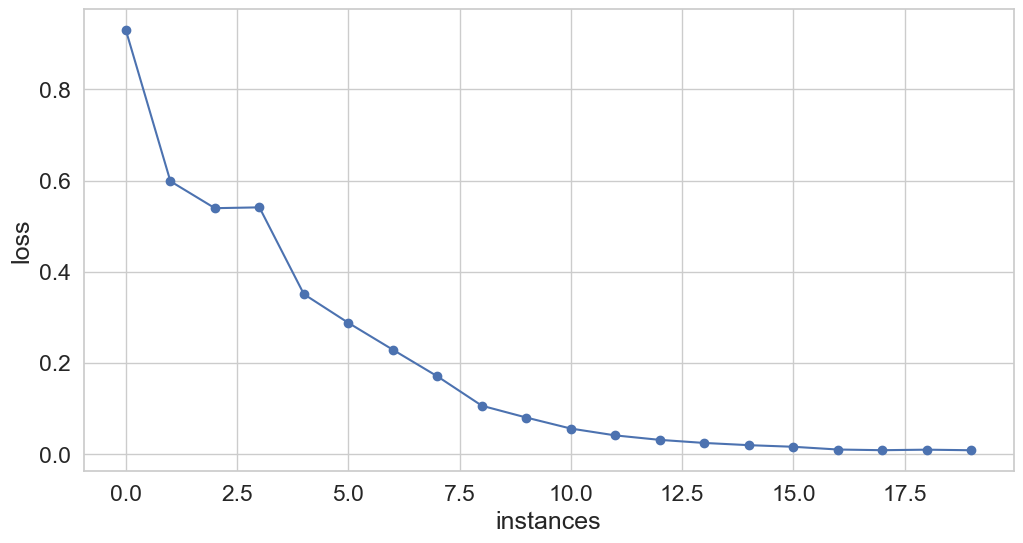

SimpleAttention(
  (W_y): Linear(in_features=3, out_features=1, bias=False)
  (tanh): Tanh()
  (softmax): Softmax(dim=0)
  (sigmoid): Sigmoid()
)

In [7]:
def train_model(model, data, epochs=20, learning_rate=0.4):
    torch.random.manual_seed(42)  
    np.random.seed(42)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate) 
    model.verbose = False
    loss_val = []
    # main training loop
    for epoch in tqdm(range(epochs), total=epochs):
        np.random.shuffle(data)
        optimizer.zero_grad() # reset all the gradient information
        for X, y in data:
            result = model.forward(X)
            loss = criterion(result[0], y)
            loss.backward()      # computes all the gradients
        optimizer.step()     # update parameters
        loss_val.append(loss.item())
    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('instances')
    plt.show()
    return model


att = SimpleAttention(input_size=3)
train_model(att, data)

In [8]:
att.verbose=True
# input is a,c,a,c
print('input=\n', X[0])
att.forward(X[0])

input=
 tensor([[1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]], dtype=torch.float64)
s=
 tensor([ 0.9999, -0.9960,  0.9999, -0.9960], dtype=torch.float64,
       grad_fn=<TanhBackward0>)
alpha=
 tensor([0.4402, 0.0598, 0.4402, 0.0598], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)
a=
 tensor([0.8804, 0.0000, 0.1196], dtype=torch.float64,
       grad_fn=<SqueezeBackward4>)
y=
 tensor([0.9933], dtype=torch.float64, grad_fn=<SigmoidBackward0>)


tensor([0.9933], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [9]:
att.W_s

Parameter containing:
tensor([ 5.1215,  4.4366, -3.1036], dtype=torch.float64, requires_grad=True)

In [10]:
att.W_y.weight

Parameter containing:
tensor([[ 5.6542, -6.0209,  0.1486]], dtype=torch.float64, requires_grad=True)

In [11]:
att.forward(torch.tensor([a,c,a,c,a,c,a,c,a,c], dtype=torch.float64))

s=
 tensor([ 0.9999, -0.9960,  0.9999, -0.9960,  0.9999, -0.9960,  0.9999, -0.9960,
         0.9999, -0.9960], dtype=torch.float64, grad_fn=<TanhBackward0>)
alpha=
 tensor([0.1761, 0.0239, 0.1761, 0.0239, 0.1761, 0.0239, 0.1761, 0.0239, 0.1761,
        0.0239], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
a=
 tensor([0.8804, 0.0000, 0.1196], dtype=torch.float64,
       grad_fn=<SqueezeBackward4>)
y=
 tensor([0.9933], dtype=torch.float64, grad_fn=<SigmoidBackward0>)


tensor([0.9933], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [12]:
att.forward(torch.tensor([a,b], dtype=torch.float64))

s=
 tensor([0.9999, 0.9997], dtype=torch.float64, grad_fn=<TanhBackward0>)
alpha=
 tensor([0.5001, 0.4999], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
a=
 tensor([0.5001, 0.4999, 0.0000], dtype=torch.float64,
       grad_fn=<SqueezeBackward4>)
y=
 tensor([0.4544], dtype=torch.float64, grad_fn=<SigmoidBackward0>)


tensor([0.4544], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

## Transformer implementation

Andrej Karpathy's excellent, simplified implementation of transformer: https://github.com/karpathy/minGPT

Along with code walkthrough video: https://www.youtube.com/watch?v=kCc8FmEb1nY

<br><br>

## Test 1

- Review quizzes and homeworks

- Question types:
  - True/False
  - Given equations, compute output
  - Given code, explain what is being computed
  - Given model, suggest an modification to address a problem
  - Given a problem, design a model
  
- Topics
  - compute classification output of logistic regression, naive bayes, neural net
  - compute parameter estimate  / step of gradient descent given equations
  - understand dimensions of weight matrices in neural nets
  - viterbi / forward-backward for HMMs
  - design choices in language models
  - pros / cons of language models, RNNs, LSTMs
 

In [13]:
from torch.nn import BCEWithLogitsLoss
import torch
loss = BCEWithLogitsLoss(reduction='none')
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

output = loss(input, target)
print(input, target, output)

tensor([0.3367, 0.1288, 0.2345], requires_grad=True) tensor([0., 1., 0.]) tensor([0.8756, 0.6308, 0.8172],
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


## sources

- https://web.stanford.edu/class/cs224n/